In [2]:
import os
import torch
from tqdm import tqdm
# torch.nn contains the building blocks for neural networks.
import torch.nn as nn # for network layers
import torch.optim as optim # for optimization algorithms
import torch.nn.functional as F # for activation funtions
from torch.utils.data import DataLoader, random_split # dataloader for batching
import torchvision.datasets as datasets # to download common datasets
import torchvision.transforms as transforms # for image preprocessing
import matplotlib.pyplot as plt # to plot examples from the dataset
from torch.utils.data.dataset import Dataset
from skimage import io # to read the images
from skimage.color import rgba2rgb # to convert the images to RGB
import numpy as np

from torch.utils.tensorboard import SummaryWriter

# to render the plots in notebooks
%matplotlib inline

### Load the data:

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainset = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
validset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


### Take a look at the data:
- How big is the dataset?
- Are the labels balanced?
- How are the images represented?
- ...

In [4]:
print("Number of training samples:", len(trainset))

Number of training samples: 60000


In [5]:
# Count the number of samples for each label
label_counts = [0] * 10  # There are 10 labels in the MNIST dataset
for data, label in trainset:
    label_counts[label] += 1

# Print the label counts
print("Label counts:", label_counts)

Label counts: [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


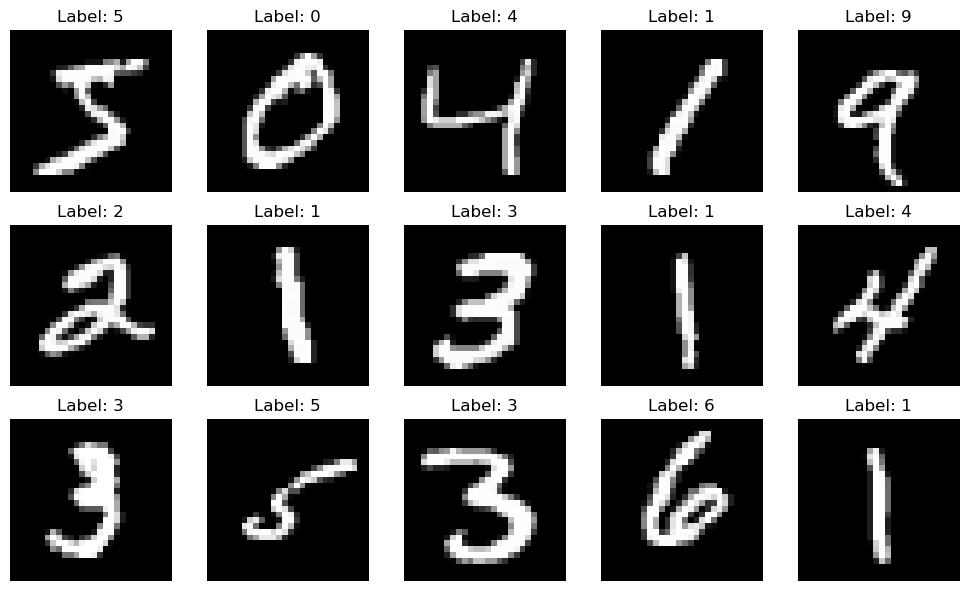

In [6]:
# Visualize some sample images
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    data, label = trainset[i]
    data = data.squeeze().numpy()
    ax.imshow(data, cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create a CNN:

In [7]:
# Define CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 7*7*64)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x


In [8]:
# Set the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Initialize the network

In [10]:
# Initialize model and move to device
model = SimpleCNN().to(device)

In [11]:
# Estimating the number of parameters
model = SimpleCNN()
print(model)

num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Number of parameters: 421642


### Define training hyperparameters

In [12]:
# training hyperparameters
batch_size = 64
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

### Create Dataloaders

In [13]:
# Create data loaders to load the data in batches
train_dataloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset=validset, batch_size=batch_size, shuffle=False)


### Write the training function
**Do** track the performance on the validation split.

In [14]:
from tqdm import tqdm

# Define training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

# Define validation function
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

### Train the model

In [15]:
# Train the model
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_acc = 0.0  # variable to keep track of the best validation accuracy

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer)
    valid_loss, valid_acc = validate(model, valid_dataloader, criterion)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")

    # Save checkpoint if validation accuracy improves
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'train_accs': train_accs,
            'valid_losses': valid_losses,
            'valid_accs': valid_accs
        }
        torch.save(checkpoint, 'checkpoint.pt')

# Save the trained model
torch.save(model.state_dict(), 'model.pth')


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 60.41it/s]


Epoch 1/10, Train Loss: 0.1331, Train Acc: 0.9587, Valid Loss: 0.0441, Valid Acc: 0.9863


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 60.42it/s]


Epoch 2/10, Train Loss: 0.0426, Train Acc: 0.9873, Valid Loss: 0.0329, Valid Acc: 0.9891


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 57.79it/s]


Epoch 3/10, Train Loss: 0.0302, Train Acc: 0.9909, Valid Loss: 0.0270, Valid Acc: 0.9909


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 55.18it/s]


Epoch 4/10, Train Loss: 0.0213, Train Acc: 0.9931, Valid Loss: 0.0330, Valid Acc: 0.9892


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 53.12it/s]


Epoch 5/10, Train Loss: 0.0171, Train Acc: 0.9944, Valid Loss: 0.0385, Valid Acc: 0.9900


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 54.36it/s]


Epoch 6/10, Train Loss: 0.0129, Train Acc: 0.9958, Valid Loss: 0.0314, Valid Acc: 0.9904


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 56.77it/s]


Epoch 7/10, Train Loss: 0.0125, Train Acc: 0.9957, Valid Loss: 0.0410, Valid Acc: 0.9882


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 55.50it/s]


Epoch 8/10, Train Loss: 0.0086, Train Acc: 0.9972, Valid Loss: 0.0352, Valid Acc: 0.9907


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 55.64it/s]


Epoch 9/10, Train Loss: 0.0065, Train Acc: 0.9978, Valid Loss: 0.0479, Valid Acc: 0.9879


100%|█████████████████████████████████████████| 157/157 [00:02<00:00, 55.26it/s]

Epoch 10/10, Train Loss: 0.0074, Train Acc: 0.9975, Valid Loss: 0.0400, Valid Acc: 0.9897


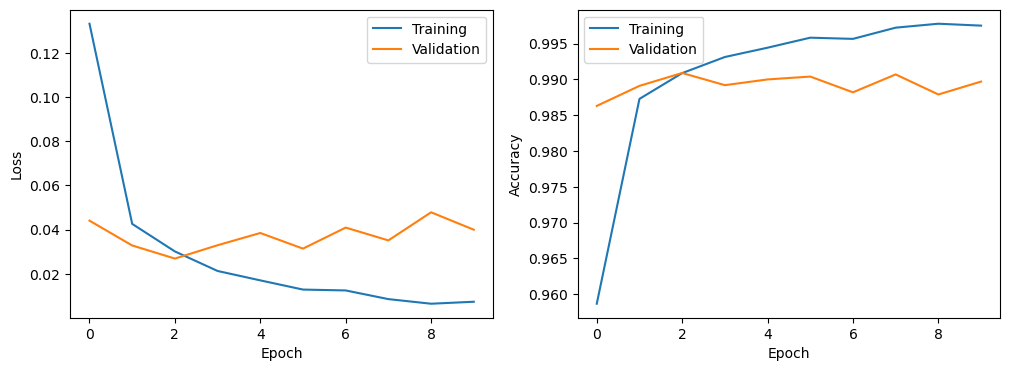

In [16]:
# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training')
plt.plot(valid_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()